In [1]:
# !python --version
# !pip --version

In [2]:
# !pip install wget
# !mkdir ./dataset
# !mkdir ./model
# !wget -nc -P ./dataset https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# !unzip -o ./dataset/ml-latest-small.zip -d ./dataset

In [3]:
# !pip install torch torch_geometric numpy matplotlib seaborn pandas
# !pip install scikit-learn
# !pip install sentence_transformers

In [4]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [5]:
from torch_geometric.datasets import MovieLens

file_path = './dataset/ml-latest-small/'

dataset = MovieLens(root=file_path)

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

2024-12-08 09:12:11,639 - INFO - Using device: cuda


In [7]:
data = dataset[0].to(device)

In [8]:
import torch_geometric.transforms as T

data['user'].x = torch.eye(data['user'].num_nodes, device=device)
del data['user'].num_nodes
data = T.ToUndirected()(data) # Add a reverse ('movie', 'rev_rates', 'user') relation for message passing:
del data['movie', 'rev_rates', 'user'].edge_label  # Remove "reverse" label.

In [9]:
# Perform a link-level split into training, validation, and test edges:
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'rates', 'movie')],
    rev_edge_types=[('movie', 'rev_rates', 'user')],
)(data)

In [10]:
weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

weight

tensor([26.1011,  7.8665,  2.7079,  1.0709,  1.0000,  2.6867], device='cuda:0')

In [11]:
train_data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 80670],
    time=[80670],
    edge_label=[80670],
    edge_label_index=[2, 80670],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 80670],
    time=[80670],
  }
)

In [12]:
val_data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 80670],
    time=[80670],
    edge_label=[10083],
    edge_label_index=[2, 10083],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 80670],
    time=[80670],
  }
)

In [13]:
test_data

HeteroData(
  movie={ x=[9742, 404] },
  user={ x=[610, 610] },
  (user, rates, movie)={
    edge_index=[2, 90753],
    time=[90753],
    edge_label=[10083],
    edge_label_index=[2, 10083],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 90753],
    time=[90753],
  }
)

In [14]:
from torch.nn import Module, Linear
from torch_geometric.nn import GCNConv, SAGEConv, to_hetero

class GNNEncoder(Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return x


class EdgeDecoder(Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class GCFModel(Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x, edge_index, edge_label_index):
        out = self.encoder(x, edge_index)
        return self.decoder(out, edge_label_index)

In [15]:
from torch.optim import Adam
import torch.nn.functional as F

model = GCFModel(hidden_channels=32).to(device)
optimizer = Adam(model.parameters(), lr=0.01)

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

def train(model):
    model.train()
    optimizer.zero_grad()
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'movie'].edge_label_index)
    target = train_data['user', 'movie'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'movie'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'movie'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()
    return float(rmse)

In [16]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'hidden_channels': [16, 32],
    'learning_rate': [0.01, 0.001],
    'batch_size': [64, 128]
}
grid = ParameterGrid(param_grid)


logging.info(f"Total parameter combinations: {len(grid)}")

best_val_rmse = float('inf')
best_params = None
best_model = None
results = []

for params in grid:
    logging.info(f"Testing params: {params}")
    hidden_channels = params['hidden_channels']
    lr = params['learning_rate']
    batch_size = params['batch_size']

    model = GCFModel(hidden_channels=hidden_channels).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(1, 151):
        loss = train(model)
        train_rmse = test(model, train_data)
        val_rmse = test(model, val_data)
        # test_rmse = test(test_data)
        
        train_losses.append(train_rmse)
        val_losses.append(val_rmse)

        # if epoch % 10 == 0:
        #     logging.info(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, Val: {val_rmse:.4f}')
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_params = params
            best_model = model

logging.info(f"Best Params: {best_params}")

2024-12-08 09:12:12,800 - INFO - Total parameter combinations: 8
2024-12-08 09:12:12,800 - INFO - Testing params: {'batch_size': 64, 'hidden_channels': 16, 'learning_rate': 0.01}
2024-12-08 09:12:16,402 - INFO - Testing params: {'batch_size': 64, 'hidden_channels': 16, 'learning_rate': 0.001}
2024-12-08 09:12:19,823 - INFO - Testing params: {'batch_size': 64, 'hidden_channels': 32, 'learning_rate': 0.01}
2024-12-08 09:12:23,509 - INFO - Testing params: {'batch_size': 64, 'hidden_channels': 32, 'learning_rate': 0.001}
2024-12-08 09:12:27,199 - INFO - Testing params: {'batch_size': 128, 'hidden_channels': 16, 'learning_rate': 0.01}
2024-12-08 09:12:30,621 - INFO - Testing params: {'batch_size': 128, 'hidden_channels': 16, 'learning_rate': 0.001}
2024-12-08 09:12:34,062 - INFO - Testing params: {'batch_size': 128, 'hidden_channels': 32, 'learning_rate': 0.01}
2024-12-08 09:12:37,760 - INFO - Testing params: {'batch_size': 128, 'hidden_channels': 32, 'learning_rate': 0.001}
2024-12-08 09:1

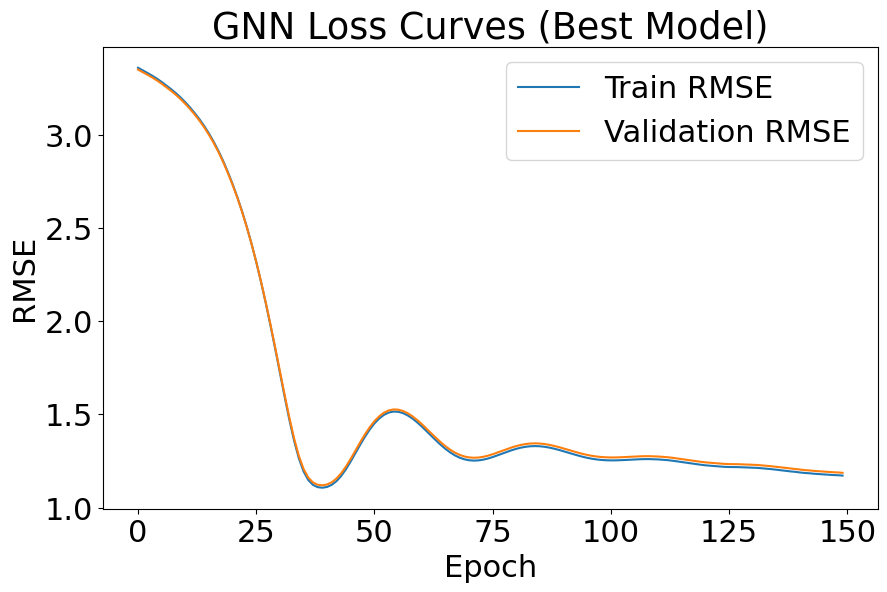

In [20]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label="Train RMSE")
plt.plot(range(len(val_losses)), val_losses, label="Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("GNN Loss Curves (Best Model)")
plt.legend()
plt.savefig("GNN Loss Curves")
plt.show()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluate Test Metrics
pred = best_model(test_data.x_dict, test_data.edge_index_dict, test_data['user', 'movie'].edge_label_index)
pred = pred.clamp(min=0, max=5)
target = test_data['user', 'movie'].edge_label.float()
rmse = float(F.mse_loss(pred, target).sqrt())

pred_labels = (pred >= 3.5).long()
target_labels = (target >= 3.5).long()

precision = precision_score(target_labels.cpu(), pred_labels.cpu(), zero_division=0)
recall = recall_score(target_labels.cpu(), pred_labels.cpu(), zero_division=0)
f1 = f1_score(target_labels.cpu(), pred_labels.cpu(), zero_division=0)
hit_ratio = (pred_labels & target_labels).sum().item() / target_labels.sum().item()

logging.info(f"Metrics: Rmse={rmse:.4f}, Hit Ratio={hit_ratio:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

2024-12-08 09:13:44,039 - INFO - Metrics: Rmse=1.1707, Hit Ratio=0.4719, Precision=0.7283, Recall=0.4719, F1=0.5727
